In [ ]:
# filepath: vscode-notebook-cell:/c%3A/Users/User/Documents/Projects/ECEG478_Project/dataTesting.ipynb#W0sZmlsZQ%3D%3D
%pip install seaborn
%pip install tqdm

In [3]:
## loading in all of the important libraries
import os
import random
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
import tqdm as tqdm

In [12]:
# loading in the two datasets (training and eval) and getting some metrics out of it
df = pd.read_csv('FairFace/fairface_label_train.csv')
df2 = pd.read_csv('FairFace/fairface_label_val.csv')
# remove service_test column
df = df.drop(columns=['service_test'])
df2 = df2.drop(columns=['service_test'])

## Combining the age bins of '60-69' and 'more than 70' into '60+' and relabeling the age bins
df['age'] = df['age'].replace({'60-69': '60+', 'more than 70': '60+'})
df2['age'] = df2['age'].replace({'60-69': '60+', 'more than 70': '60+'})

# rename Latino_Hispanic to Latino
df['race'] = df['race'].replace({'Latino_Hispanic': 'Latino'})
df2['race'] = df2['race'].replace({'Latino_Hispanic': 'Latino'})

# confirmation check
# print("Value counts AFTER replacement, BEFORE filtering:")
# print(df['age'].value_counts())
# print(f"Total rows before filtering: {len(df)}")

df = df.drop_duplicates(subset=['file'], keep='first')
df2 = df2.drop_duplicates(subset=['file'], keep='first')



# encoding categorical labels
age_bins = ['0-2', '3-9', '10-19', '20-29', '30-39', '40-49', '50-59', '60+']

# new column 'age' with the bins from above
df = df[df['age'].isin(age_bins)]  # ensure only those bins are used
df2 = df2[df2['age'].isin(age_bins)] 


# confirmation check post transform
# print("\nValue counts AFTER filtering:")
# print(df['age'].value_counts())
# print(f"Total rows after filtering: {len(df)}")


## these will be used to check what the encoding and decoding looks like
age_encoder = LabelEncoder()
df['age_label'] = age_encoder.fit_transform(df['age'])
df2['age_label'] = age_encoder.fit_transform(df2['age'])


gender_encoder = LabelEncoder()
df['gender_label'] = gender_encoder.fit_transform(df['gender'])
df2['gender_label'] = gender_encoder.fit_transform(df2['gender'])


race_encoder = LabelEncoder()
df['race_label'] = race_encoder.fit_transform(df['race'])
df2['race_label'] = race_encoder.fit_transform(df2['race'])



## generate random int in general
def random_int(min_val, max_val):
    # function that generates a random int between two input ranges
    return np.random.randint(min_val, max_val + 1)

def balance_by_multiple_attributes(df, attr_cols, n_per_group):
    # function that balances the dataset by multiple attributes
    
    state_value = random_int(0, 140) ## for creating a random-random state
    ## I saw that using a static random state value of 0 was causing the same random sample to be generated every time
    
    grouped = df.groupby(attr_cols)
    print("Grouped DataFrame:")
    print(grouped.head())
    balanced_df = grouped.apply(lambda x: x.sample(n=min(len(x), n_per_group), random_state=state_value))
    balanced_df = balanced_df.reset_index(drop=True)
    return balanced_df

In [13]:
# TODO: I think creating a new set to sample from would be better than sampling from the original set
## This is not being used right now, but this can be used as a reference for the future

### These would be the larger sets (still smaller than the original set) that we can sample from
# trainSet = balance_by_multiple_attributes(df, ['age_label', 'gender_label', 'race_label'], 500)
# trainSet = trainSet.sample(frac=1, random_state=random_int(0,1500)).reset_index(drop=True)

valSet = balance_by_multiple_attributes(df2, ['age_label', 'gender_label', 'race_label'], 100)
# valSet = valSet.sample(frac=1, random_state=random_int(0,1500)).reset_index(drop=True)
# print(valSet['file'].unique().shape)
# print(valSet)

# # ===================================================================================


# trainingSet = balance_by_multiple_attributes(df, ['age_label', 'gender_label', 'race_label'], 250)
# ## remove age and gender columns
# trainingSet = trainingSet.drop(['age', 'gender','race'], axis=1)

# ## remove indices that are in the training column so that they don't end up in the validation set
# remaining = df[~df['file'].isin(trainingSet['file'])]

# validationSet = balance_by_multiple_attributes(remaining, ['age_label', 'gender_label', 'race_label'], 25)
# ## remove
# validationSet = validationSet.drop(['age', 'gender','race'], axis=1)

# ## just double checking that there are no overlap between the two sets
# # check the file name of the training and validation sets via if loop (using tqdm?)
# training_files = set(trainingSet['file'])
# validation_files = set(validationSet['file'])

# print(training_files)
# print(validation_files)

# print(f"overlap b/w training and validation sets: {overlap}")
# print(f"size of overlap: {len(overlap)}")


# print(newSet.head())

Grouped DataFrame:
              file    age  gender             race  age_label  gender_label  \
0        val/1.jpg    3-9    Male       East Asian          3             1   
1        val/2.jpg  50-59  Female       East Asian          6             0   
2        val/3.jpg  30-39    Male            White          4             1   
3        val/4.jpg  20-29  Female           Latino          2             0   
4        val/5.jpg  20-29    Male  Southeast Asian          2             1   
...            ...    ...     ...              ...        ...           ...   
6107  val/6108.jpg    0-2  Female   Middle Eastern          0             0   
6262  val/6263.jpg    0-2  Female           Latino          0             0   
6786  val/6787.jpg    0-2    Male           Latino          0             1   
7372  val/7373.jpg    0-2    Male           Latino          0             1   
9317  val/9318.jpg    0-2  Female            Black          0             0   

      race_label  
0            

C:\Users\User\AppData\Local\Temp\ipykernel_23232\942877382.py:71: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  balanced_df = grouped.apply(lambda x: x.sample(n=min(len(x), n_per_group), random_state=state_value))


              file    age  gender             race  age_label  gender_label  \
0     val/2890.jpg  30-39    Male           Indian          4             1   
1     val/1835.jpg    3-9    Male            Black          3             1   
2     val/8980.jpg    3-9    Male  Southeast Asian          3             1   
3     val/8228.jpg  30-39    Male       East Asian          4             1   
4     val/3689.jpg  30-39  Female           Indian          4             0   
...            ...    ...     ...              ...        ...           ...   
7703  val/6864.jpg  10-19  Female            Black          1             0   
7704  val/9091.jpg  30-39  Female  Southeast Asian          4             0   
7705  val/4253.jpg  40-49    Male   Middle Eastern          5             1   
7706   val/737.jpg    3-9    Male            White          3             1   
7707  val/5974.jpg    3-9    Male           Indian          3             1   

      race_label  
0              2  
1            

Text(0, 0.5, 'Count')

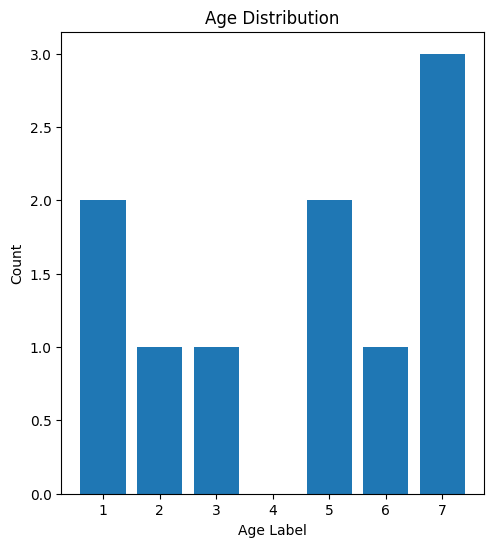

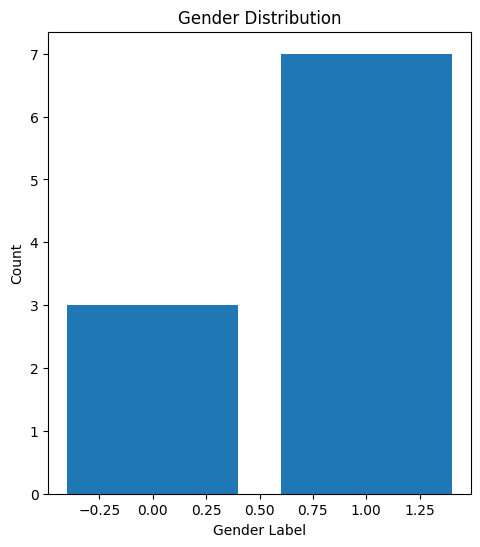

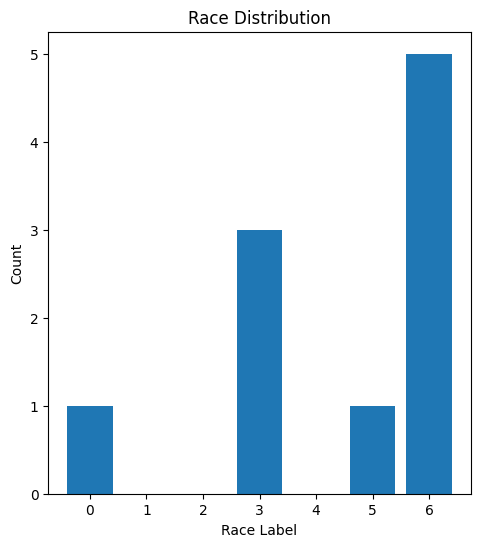

In [690]:
# Validation set output
# name = valSet
print(valSet)
## Age labels
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.bar(name['age_label'].value_counts().index, name['age_label'].value_counts().values)
plt.title('Age Distribution')
plt.xlabel('Age Label')
plt.ylabel('Count')

## count how many are label 7 and 8
print(name['age_label'].value_counts())
# 3270 as a combination of 7 and 8 before combinations
# 

## Gender labels
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.bar(name['gender_label'].value_counts().index, name['gender_label'].value_counts().values)
plt.title('Gender Distribution')
plt.xlabel('Gender Label')
plt.ylabel('Count')

## Race labels
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.bar(name['race_label'].value_counts().index, name['race_label'].value_counts().values)
plt.title('Race Distribution')
plt.xlabel('Race Label')
plt.ylabel('Count')

In [ ]:
# ## export the training and validation sets to csv files

# # before randomizing
# print("Before randomizing:")
# print(trainingSet.head())
# print(validationSet.head())
# print("================================================================")

# # randomize the training and validation sets
# trainingSet = trainingSet.sample(frac=1, random_state=42).reset_index(drop=True)
# validationSet = validationSet.sample(frac=1, random_state=42).reset_index(drop=True)

# # after randomizing
# print(trainingSet.head())
# print(validationSet.head())

# # create a new direcotry called Datasets
# if not os.path.exists('Datasets'):
#     os.makedirs('Datasets')

# trainingSet.to_csv('Datasets/trainingSet.csv', index=False)
# validationSet.to_csv('Datasets/validationSet.csv', index=False)


In [587]:

## Output of Encoding for age and race
# tester111 = (list(zip(age_encoder.classes_, range(len(age_encoder.classes_)))))  ## output is in format of [(class, index), ...]
tester111 = (list(zip(gender_encoder.classes_, range(len(gender_encoder.classes_)))))

## need to change to [class, class, class, ...]
for i in range(len(tester111)):
    tester111[i] = tester111[i][0]
print(tester111)
    
# print(list(zip(gender_encoder.classes_, range(len(gender_encoder.classes_)))))
# print(list(zip(race_encoder.classes_, range(len(race_encoder.classes_)))))

def getEncodeDecoded():
    print((list(zip(age_encoder.classes_, range(len(age_encoder.classes_))))))
    print(list(zip(gender_encoder.classes_, range(len(gender_encoder.classes_)))))
    print(list(zip(race_encoder.classes_, range(len(race_encoder.classes_)))))


['Female', 'Male']


In [15]:
import torch, random
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL   import Image
from pathlib import Path

# ── transforms ──────────────────────────────────────────────
IMG_SIZE = 224
train_tfms = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.CenterCrop(IMG_SIZE),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],
                         [0.229,0.224,0.225])
])

val_tfms = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.CenterCrop(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],
                         [0.229,0.224,0.225])
])

# ── dataset ─────────────────────────────────────────────────
class FairFaceMulti(Dataset):
    def __init__(self, df, img_dir, train=True):
        self.df       = df.reset_index(drop=True)
        self.img_dir  = Path(img_dir)
        self.tfm      = train_tfms if train else val_tfms

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row   = self.df.iloc[idx]
        img_p = self.img_dir / Path(row.file).name   # robust join
        img   = Image.open(img_p).convert("RGB")
        age    = torch.tensor(row.age_label,    dtype=torch.long)
        gender = torch.tensor(row.gender_label, dtype=torch.long)
        race = torch.tensor(row.race_label, dtype=torch.long)

        return self.tfm(img), {"age": age, "gender": gender, "race": race}

    def __str__(self):
        return f"FairFaceMulti(n={len(self)}, dir={self.img_dir})"



In [16]:
import torch.nn as nn
import torchvision.models as models

class AgeGenderNet(nn.Module):
    def __init__(self, n_age=9, n_gender=2, n_race=7, backbone="resnet18"):
        super().__init__()
        self.backbone = getattr(models, backbone)(weights="IMAGENET1K_V1")
        dim = self.backbone.fc.in_features
        self.backbone.fc = nn.Identity()          # remove final FC

        self.age_head    = nn.Linear(dim, n_age)      # 9 classes
        self.gender_head = nn.Linear(dim, n_gender)   # 2 classes
        self.race_head = nn.Linear(dim, n_race)   # 2 classes


    def forward(self, x):
        feat = self.backbone(x)
        return {
            "age":    self.age_head(feat),
            "gender": self.gender_head(feat),
            "race": self.race_head(feat)

        }

model = AgeGenderNet().cuda()
loss_age    = nn.CrossEntropyLoss()
loss_gender = nn.CrossEntropyLoss()     # fairly balanced already
loss_race = nn.CrossEntropyLoss()     # fairly balanced already


def criterion(pred_dict, target_dict, λ_age=1.0, λ_gender=1.0, λ_race=1.0):
    L_age    = loss_age(pred_dict["age"],    target_dict["age"])
    L_gender = loss_gender(pred_dict["gender"], target_dict["gender"])
    L_race = loss_race(pred_dict["race"], target_dict["race"])

    
    return λ_age*L_age + λ_gender*L_gender + λ_race*L_race , {"age": L_age.item(),
                                            "gender": L_gender.item(), "race": L_race.item()}
    
    
## optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-4, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

In [ ]:
# check nvidia-smi
nvidia_smi = os.popen("nvidia-smi").read()
!nvidia-smi
# check if GPU is available
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(device)

In [17]:
def run_epoch(loader, train=True):
    model.train() if train else model.eval()
    epoch_loss, correct_age, correct_gender, correct_race, n = 0,0,0,0,0 # Initialize n=0
    print(f"Starting {'training' if train else 'validation'} epoch...")
    batch_num = 0
    for imgs, targets in tqdm.tqdm(loader):
        # print(f"Processing batch {batch_num}")
        batch_num += 1
        try:
            imgs = imgs.cuda()
            t_age    = targets["age"].cuda()
            t_gender = targets["gender"].cuda()
            t_race   = targets["race"].cuda() # Get race target

            with torch.set_grad_enabled(train):
                preds = model(imgs)
                loss, parts = criterion(preds, {"age":t_age, "gender":t_gender, "race": t_race}) # Include race in criterion if needed

            if train:
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            _, pa = preds["age"].max(1)
            _, pg = preds["gender"].max(1)
            _, pr = preds["race"].max(1) # Use pr for race prediction index

            correct_age    += (pa==t_age).sum().item()
            correct_gender += (pg==t_gender).sum().item()
            correct_race   += (pr==t_race).sum().item() # Calculate correct race predictions

            n += imgs.size(0)
            epoch_loss += loss.item()*imgs.size(0)
        except Exception as e:
            print(f"Error in batch {batch_num-1}: {e}")
            # Decide if you want to stop or continue
            # raise # Re-raise the exception to stop execution
            # continue # Skip this batch and continue

    print(f"Finished {'training' if train else 'validation'} epoch.")
    # Handle potential division by zero if n remains 0
    if n == 0:
        print("Warning: No items processed in the loader.")
        return (0, 0, 0, 0) # Return 4 zeros
    # Return loss and all three accuracies
    return (epoch_loss/n,
            correct_age/n,
            correct_gender/n,
            correct_race/n) # Add race accuracy to the return tuple

In [ ]:

## just recalling the variables
trainingSet = trainingSet
validationSet = validationSet

In [18]:
import os, time, datetime
from statistics import mean

## the actual training
train_ds = FairFaceMulti(trainingSet,   "FairFace/train", train=True)
val_ds   = FairFaceMulti(validationSet, "FairFace/train", train=True)

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True,  num_workers=0, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=64, shuffle=True, num_workers=0, pin_memory=True)
    
# Check the length of the dataset
print(f"Length of train_loader: {len(train_loader)}")
print(f"Length of val_loader: {len(val_loader)}")

## location to store models
if not os.path.exists('checkpoints'):
    os.makedirs('checkpoints')

EPOCHS = 10
# to keep track of time
epoch_times = [] 



for epoch in range(EPOCHS):
    t0 = time.time()
    
    tr_loss, tr_acc_age, tr_acc_gen, tr_acc_race = run_epoch(train_loader, train=True)
    vl_loss, vl_acc_age, vl_acc_gen, vl_acc_race = run_epoch(val_loader,   train=True)
    scheduler.step()
    # Initialize variables for ETA calculation
    start_time = time.time()

    # Calculate elapsed time and ETA
    epoch_times.append(time.time() - t0)
    avg_epoch   = mean(epoch_times)
    remaining   = EPOCHS - (epoch + 1)
    eta_seconds = avg_epoch * remaining
    eta_str     = str(datetime.timedelta(seconds=int(eta_seconds)))

    # Format ETA as HH:MM:SS
    eta_formatted = time.strftime("%H:%M:%S", time.gmtime(eta))
    
    ## incramentally save the model after every 20 epochs
    if (epoch+1) % 20 == 0:
        torch.save(model.state_dict(), f"checkpoints/model_epoch_{epoch+1}.pth")
        print(f"Model saved at epoch {epoch+1}")

    # Print metrics
    print(
        f"{epoch:02d}  "
        f"tr_loss={tr_loss:.3f}  vl_loss={vl_loss:.3f} |\n"
        f"TRAIN  age={tr_acc_age:.2%}  gen={tr_acc_gen:.2%}  race={tr_acc_race:.2%} |\n"
        f"VAL    age={vl_acc_age:.2%}  gen={vl_acc_gen:.2%}  race={vl_acc_race:.2%} |\n"
        f"ETA ~ {eta_str}")

Length of train_loader: 400
Length of val_loader: 34
Starting training epoch...


  5%|▌         | 21/400 [00:07<02:23,  2.65it/s]


KeyboardInterrupt: 

In [ ]:
# saving the model after training

ckpt_path = "checkpoints/best_multitask.pth"
ckpt = {
    "epoch"      : epoch,
    "model_state": model.state_dict(),
    "optimizer"  : optimizer.state_dict(),   # optional
    "age_encoder": age_encoder.classes_.tolist(),  # any extra objects you need
}
torch.save(ckpt, ckpt_path)
print("✅  Saved checkpoint →", ckpt_path)


In [ ]:

# # images need to be randomly selected
# import random

# # loading in the dataset and getting some metrics out of it
# testSet = pd.read_csv('FairFace/fairface_label_val.csv')

# # remove service_test column
# testSet = testSet.drop(columns=['service_test'])
# ## Combining the age bins of '60-69' and 'more than 70' into '60+' and relabeling the age bins
# testSet['age'] = testSet['age'].replace({'60-69': '60+', 'more than 70': '60+'})
# # rename Latino_Hispanic to Latino
# testSet['race'] = testSet['race'].replace({'Latino_Hispanic': 'Latino'})

# testSet = testSet.drop_duplicates(subset=['file'], keep='first')


# # encoding categorical labels
# age_bins = ['0-2', '3-9', '10-19', '20-29', '30-39', '40-49', '50-59', '60+']

# # new column 'age' with the bins from above
# testSet = testSet[testSet['age'].isin(age_bins)]  # ensure only those bins are used

# ## these will be used to check what the encoding and decoding looks like
# age_encoder = LabelEncoder()
# testSet['age_label'] = age_encoder.fit_transform(testSet['age'])

# gender_encoder = LabelEncoder()
# testSet['gender_label'] = gender_encoder.fit_transform(testSet['gender'])

# race_encoder = LabelEncoder()
# testSet['race_label'] = race_encoder.fit_transform(testSet['race'])



In [7]:
import random
import shutil

# --- Make sure valSet is defined correctly from your validation data ---
# Example: valSet = validationSet # Assuming validationSet is your DataFrame

## Need to take around 25-30 image from the val folder in FairFace and put them in a folder called test
# define the two source base directory and the destination directory


def createTestSet(TEST_SIZE):
    df_source = valSet.copy()
    source_base_dir = "FairFace" ## where it's coming from
    test_dir = "FairFace/test"   ## where it'll go

    if not os.path.exists(test_dir):
        os.makedirs(test_dir)
        
    ## check what files are in the directory and remove all
    for filename in os.listdir(test_dir):
        file_path = os.path.join(test_dir, filename)
        try:
            if os.path.isfile(file_path):
                os.remove(file_path)
                # print(f"Removed {file_path}")
        except Exception as e:
            print(f"Error removing {file_path}: {e}")

    # get a list of all the files (relative paths like 'val/xxxx.jpg') in the validation set
    
    testFiles = df_source['file'].tolist()
    random_files = [] # initalize empty list first

    # this randomly select 25 files
    
    if len(testFiles) >= 25:
        random_files = random.sample(testFiles, TEST_SIZE)
    else:
        print(f"Warning: Only {len(testFiles)} files available in validation set. Selecting all.")
        # random_files = testFiles
        # print(testFiles)
        # print(len(random_files))

    # print(f"Attempting to copy {len(random_files)} files to {test_dir}...")
    # print(len(random_files))

    # Copy the files to the test directory
    for file_relative_path in random_files:
        # source path
        src = os.path.join(source_base_dir, file_relative_path)
        # file name
        file_basename = os.path.basename(file_relative_path)
        # dest pat
        dst = os.path.join(test_dir, file_basename)
        
        # loop through the files and copy them to the test directory
        try:
            if os.path.exists(src):
                shutil.copy2(src, dst) # Use shutil.copy2 for better copying
                # print(f"Copied {src} to {dst}")
            else:
                print(f"Error: Source file {src} does not exist.")
        except Exception as e:
            print(f"Error copying {src} to {dst}: {e}")

    print("Finished copying files.")

    ## Now need to create a new CSV file for all of the information regarding the files in the test directory
    # gen idea is to go call the val csv file and drop all rows that do not have the file name in the test directory

    files = os.listdir(test_dir)
    # Get the file names without the dir path
    files = [os.path.basename(file) for file in files]

    # new of val labels
    ## file column contains file names in the style of val/xxxx.jpg
    # filter df2 to only include rows where the 'file' column matches any of the file names in the test directory
    # Extract the basename from the 'file' column in df2
    df2_basenames = df_source['file'].str.split('/').str[-1]

    # Filter df2 where the basename is in the 'files' list
    current_sef_labels_df = df_source[df2_basenames.isin(files)].copy() # Use .copy() to avoid some err
    # testertester.drop(columns=['age_label', 'gender_label', 'race_label'], inplace=True)
    # print(testertester)

    ## save as csv in the file path
    current_sef_labels_df.to_csv('FairFace/fairface_label_test.csv', index=False)
    
    return current_sef_labels_df
createTestSet(25)

Finished copying files.


,file,age,gender,race,age_label,gender_label,race_label
161,val/1282.jpg,30-39,Male,Latino,4,1,3
819,val/8288.jpg,30-39,Female,East Asian,4,0,1
855,val/9785.jpg,10-19,Female,White,1,0,6
870,val/8661.jpg,20-29,Male,Black,2,1,0
1096,val/10874.jpg,3-9,Female,Southeast Asian,3,0,5
1393,val/4092.jpg,40-49,Male,Latino,5,1,3
1406,val/1705.jpg,30-39,Male,Indian,4,1,2
1765,val/491.jpg,10-19,Female,Black,1,0,0
2264,val/2946.jpg,40-49,Male,Southeast Asian,5,1,5
2329,val/398.jpg,30-39,Male,Black,4,1,0


In [676]:
## Testing the model
## select the model
model = AgeGenderNet()
model.load_state_dict(torch.load(r"checkpoints\model_epoch_200.pth"))
model.eval()                      
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

@torch.inference_mode()                  # no gradients, saves memory
def predict_img(img_path: str):
    img = Image.open(img_path).convert("RGB")
    x   = val_tfms(img).unsqueeze(0).to(device)     # shape (1,3,224,224)

    out = model(x)                       # tuple OR dict, depending on your net
    age_id    = out["age"].argmax(1).item()
    gender_id = out["gender"].argmax(1).item()
    race_id   = out["race"].argmax(1).item()
    
    # print("ID INFO")
    # print(f"Age ID: {age_id}, Gender ID: {gender_id}, Race ID: {race_id}")

    # class-name look-up tables (same order you used to encode)
    age_classes = (list(zip(age_encoder.classes_, range(len(age_encoder.classes_)))))  ## output is in format of [(class, index), ...]
    gender_map = (list(zip(gender_encoder.classes_, range(len(gender_encoder.classes_)))))
    race_classes = (list(zip(race_encoder.classes_, range(len(race_encoder.classes_)))))
    
    ## need to change to [class, class, class, ...]
    for i in range(len(age_classes)):
        age_classes[i] = age_classes[i][0]
    # print(age_classes)
    
    ## repeat for the other two
    for i in range(len(gender_map)):
        gender_map[i] = gender_map[i][0]
    # print(gender_map)
    
    for i in range(len(race_classes)):
        race_classes[i] = race_classes[i][0]
    # print(race_classes)
            
    return age_classes[age_id], gender_map[gender_id], race_classes[race_id]


# img_dir = r"FairFace/test/2548.jpg"
# result = predict_img(img_dir)   # any face image
# print(result)

C:\Users\User\AppData\Local\Temp\ipykernel_41780\1567078367.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(r"checkpoints\model_epoch_20

In [738]:
# load in testing csv set



## test with batches
def model_test_batch():
    valFilePath = "FairFace/fairface_label_test.csv"
    valSet = pd.read_csv(valFilePath)
    test_path = r"FairFace\test"

    # get all files in the test directory, in format: FairFace/test/xxxx.jpg
    test_files = os.listdir(test_path)
    test_files = [os.path.join(test_path, file) for file in test_files]
    
    # extract values of age_range, gender, and race from the valSet and save it to a list for accuracy comparison later
    # this should only already contain the files that are in the test directory
    # age list should be: [3-9, 10-19, 20-29, 30-39, 40-49, 50-59, 60+, ...] for each image
    
    true_age_list = valSet['age'].tolist()
    true_gender_list = valSet['gender'].tolist()
    true_race_list = valSet['race'].tolist()
    
    # print(true_age_list)
    
    # empty lists to store the predictions
    pred_age_list = []
    pred_gender_list = []
    pred_race_list = []
    
    # loop through the test files and get the predictions
    for file in test_files:
        pred_age, pred_gender, pred_race = predict_img(file)
        pred_age_list.append(pred_age), pred_gender_list.append(pred_gender), pred_race_list.append(pred_race)
    # print(pred_age_list)
    # print accuracies
    print(f"Age accuracy: {accuracy_score(true_age_list, pred_age_list)}\n"
          f"Gender Accuracy: {accuracy_score(true_gender_list, pred_gender_list)}\n"
          f"Race Accuracy: {accuracy_score(true_race_list, pred_race_list)}")
    
createTestSet(25)
model_test_batch()
    

Finished copying files.
Age accuracy: 0.24
Gender Accuracy: 0.6
Race Accuracy: 0.12


In [739]:
def testDiffTestSizes():
    # Define the test sizes you want to try
    test_sizes = [10, 25, 50, 100, 500, 1000, 2000]

    # Loop through each test size
    for size in test_sizes:
        print(f"Testing with {size} images:")
        createTestSet(size)
        model_test_batch()
        print("\n" + "="*50 + "\n")  # Separator for readability

testDiffTestSizes()
# print(testFiles)

Testing with 10 images:
Finished copying files.
Age accuracy: 0.0
Gender Accuracy: 0.4
Race Accuracy: 0.1


Testing with 25 images:
Finished copying files.
Age accuracy: 0.28
Gender Accuracy: 0.4
Race Accuracy: 0.16


Testing with 50 images:
Finished copying files.
Age accuracy: 0.14
Gender Accuracy: 0.52
Race Accuracy: 0.08


Testing with 100 images:
Finished copying files.
Age accuracy: 0.21
Gender Accuracy: 0.54
Race Accuracy: 0.21


Testing with 500 images:
Finished copying files.
Age accuracy: 0.138
Gender Accuracy: 0.476
Race Accuracy: 0.156


Testing with 1000 images:
Finished copying files.
Age accuracy: 0.146
Gender Accuracy: 0.541
Race Accuracy: 0.152


Testing with 2000 images:
Finished copying files.
Age accuracy: 0.1395
Gender Accuracy: 0.503
Race Accuracy: 0.124


